Mounted at /content/gdrive
   YEAR  TIME_PRECISION EVENT_TYPE   LOCATION  LATITUDE  LONGITUDE  \
0  2001               1    Battles   Lohagara   23.1998    89.6644   
1  2001               1      Riots  Hathazari   22.5052    91.8134   
2  2001               1      Riots  Rangamati   22.6432    92.1919   
3  2001               1      Riots     Rajoir   23.1878    90.0322   
4  2001               1      Riots   Rajshahi   24.3740    88.6011   

   FATALITIES  WRapeIncident  WRapeDeath  BD_GDP  BD_GDP_GR  \
0           1            183         135     415      -0.73   
1           0            183         135     415      -0.73   
2           0            183         135     415      -0.73   
3           0            183         135     415      -0.73   
4           0            183         135     415      -0.73   

   ChildrenMortalityRate  AvgPopulationdensity  
0                   60.3           2307557.908  
1                   60.3           2307557.908  
2                   60.3  

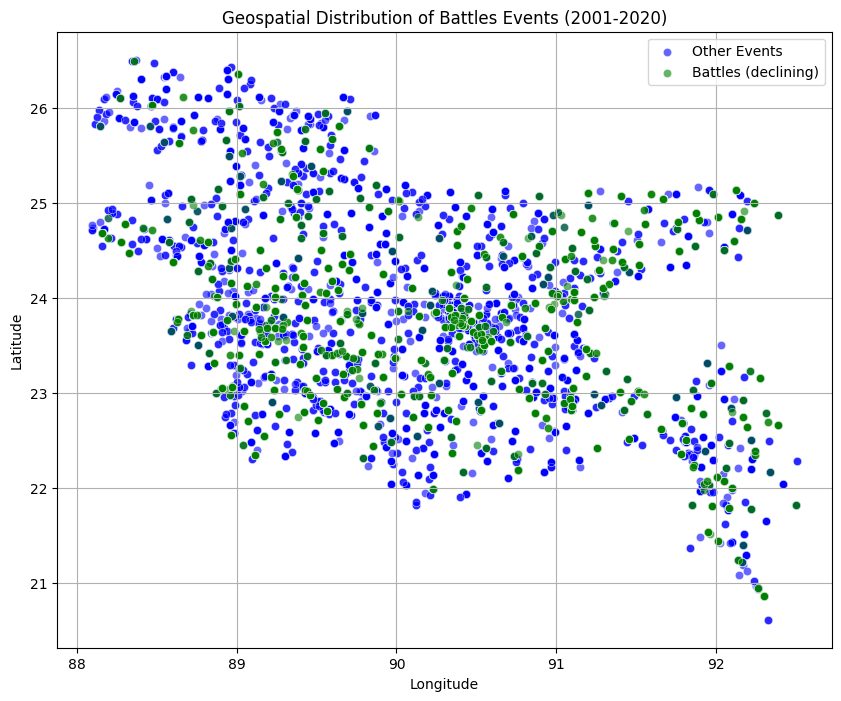

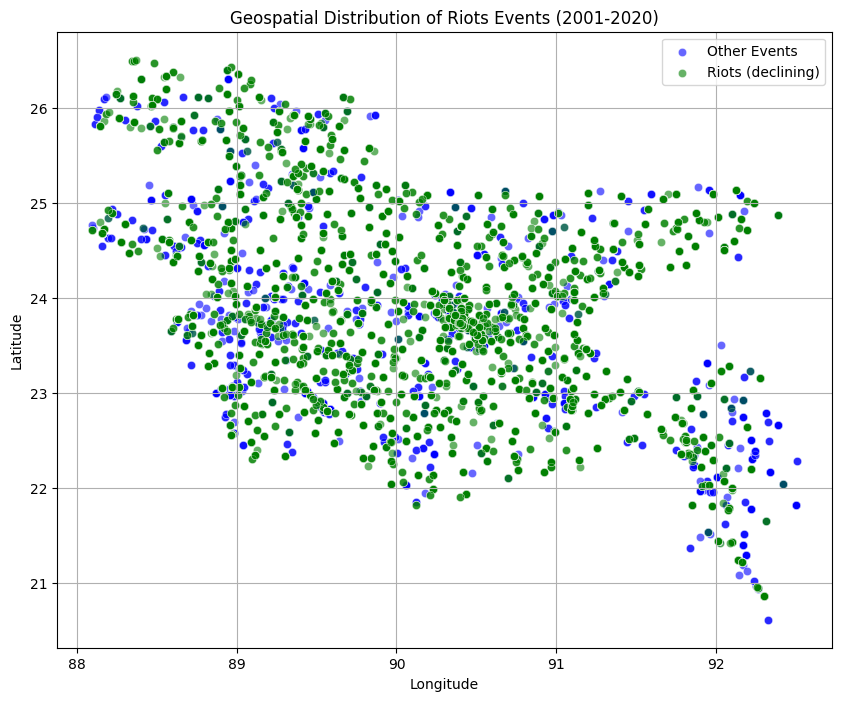

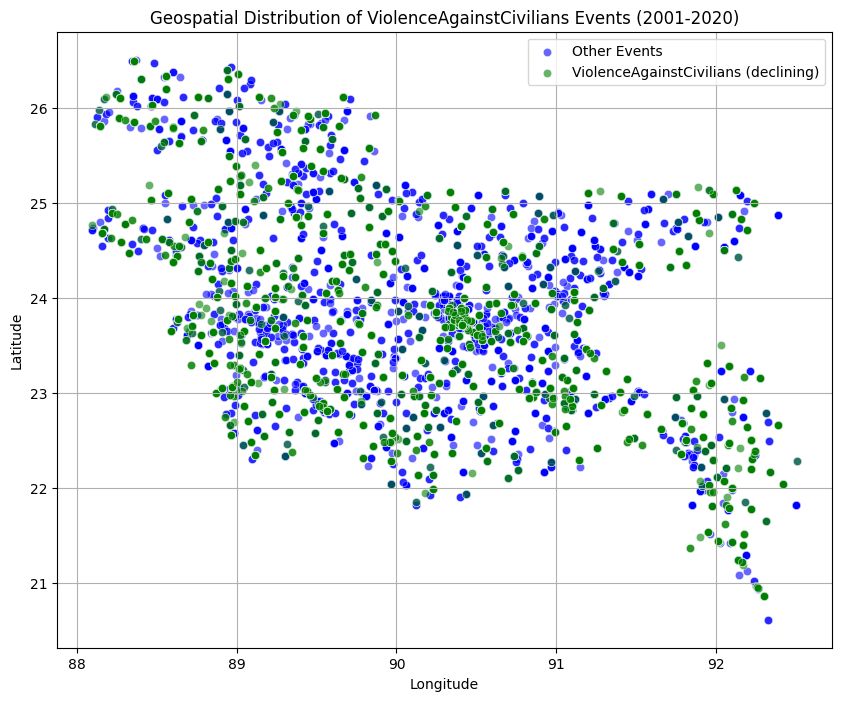

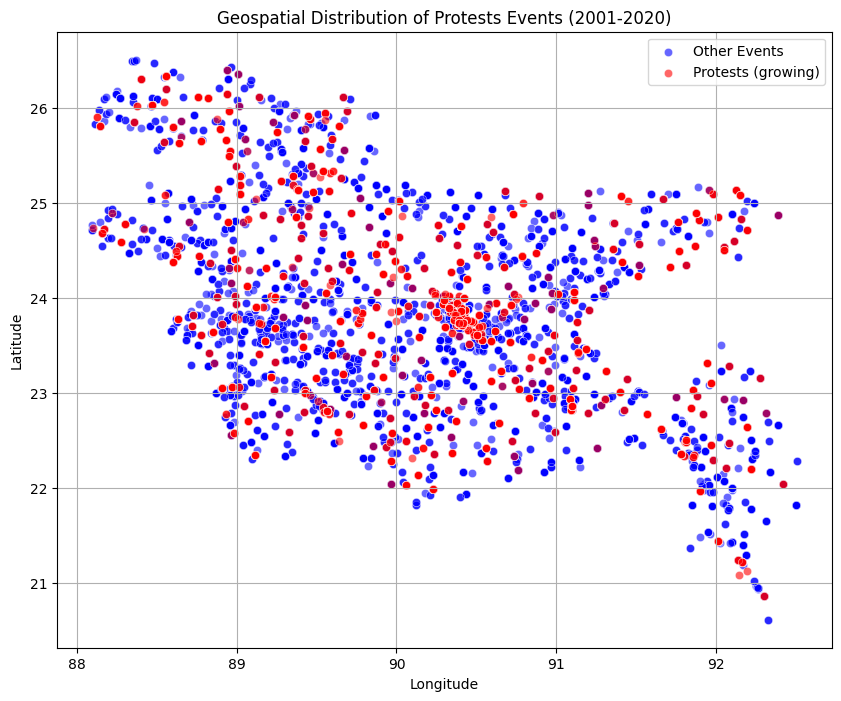

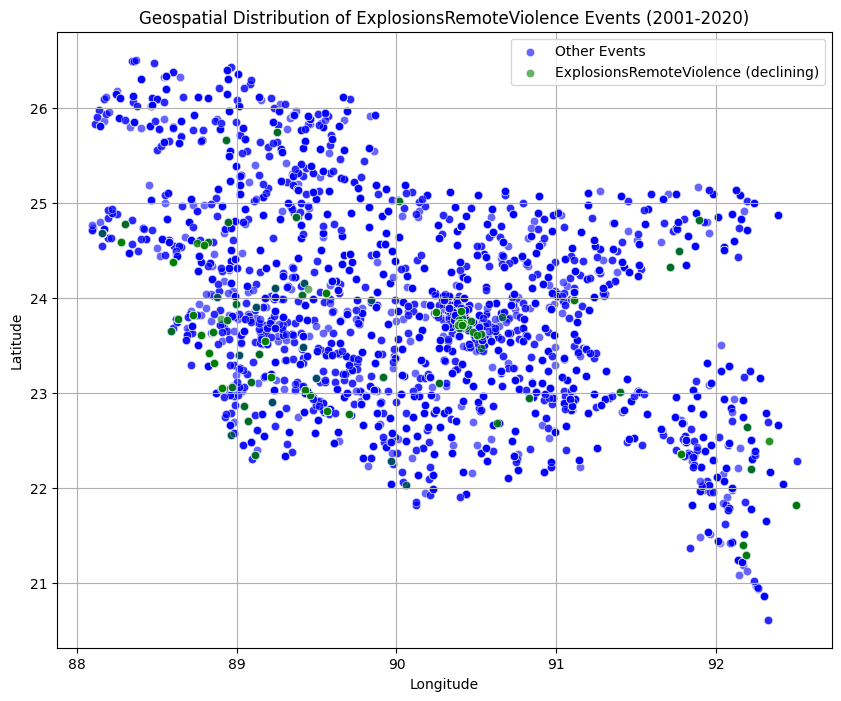

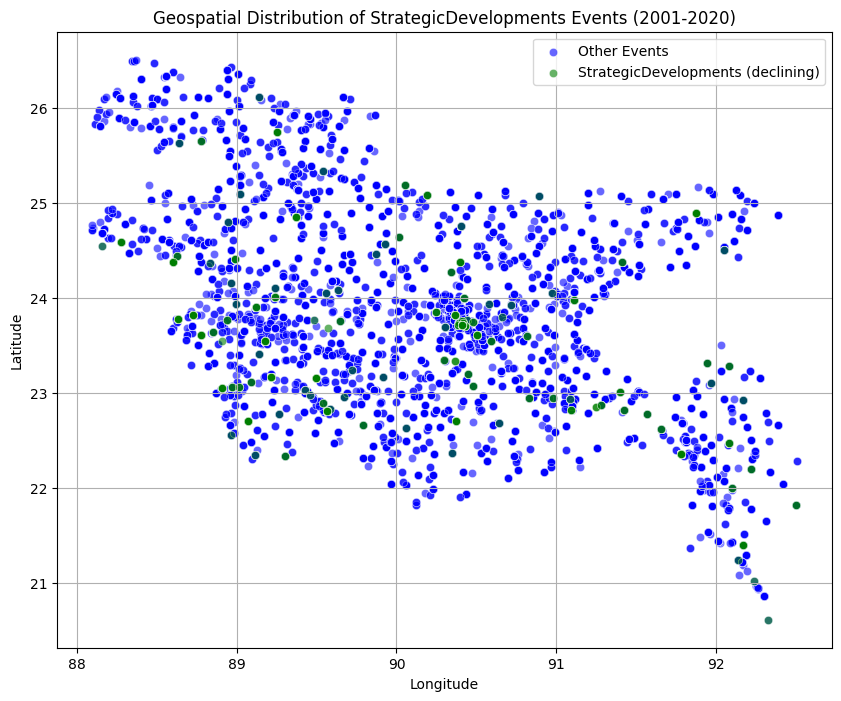

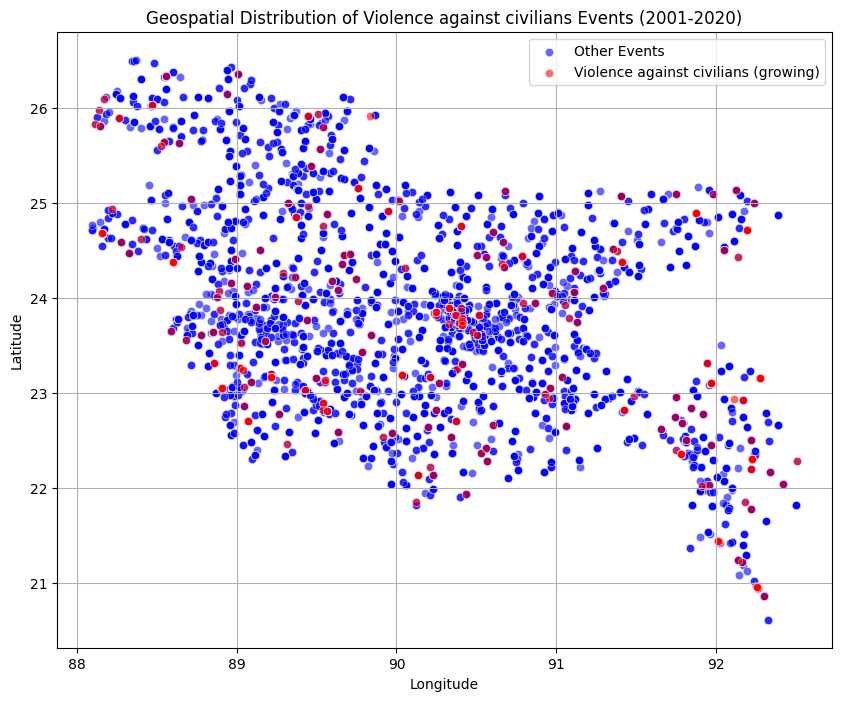

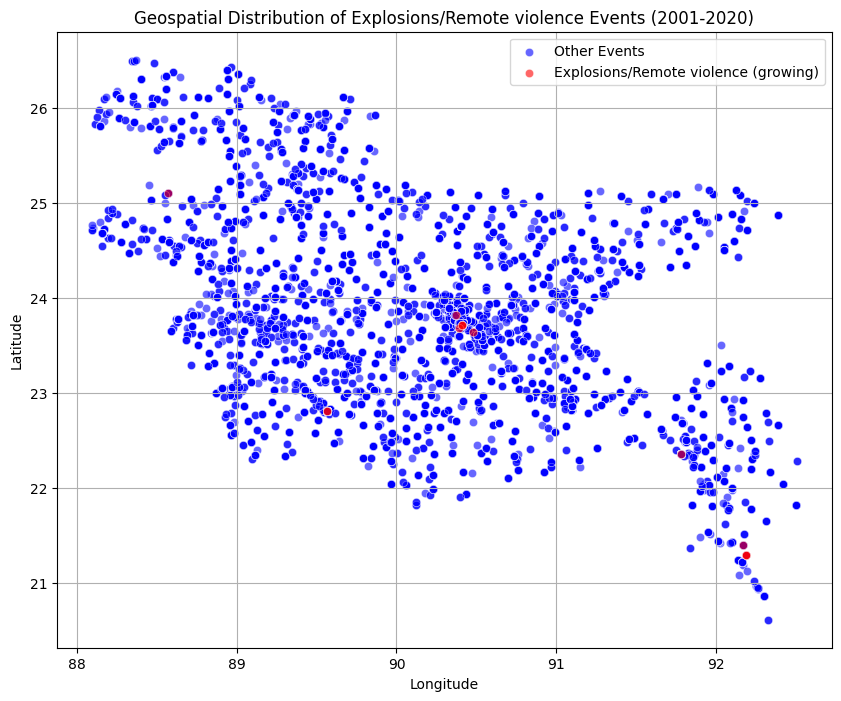

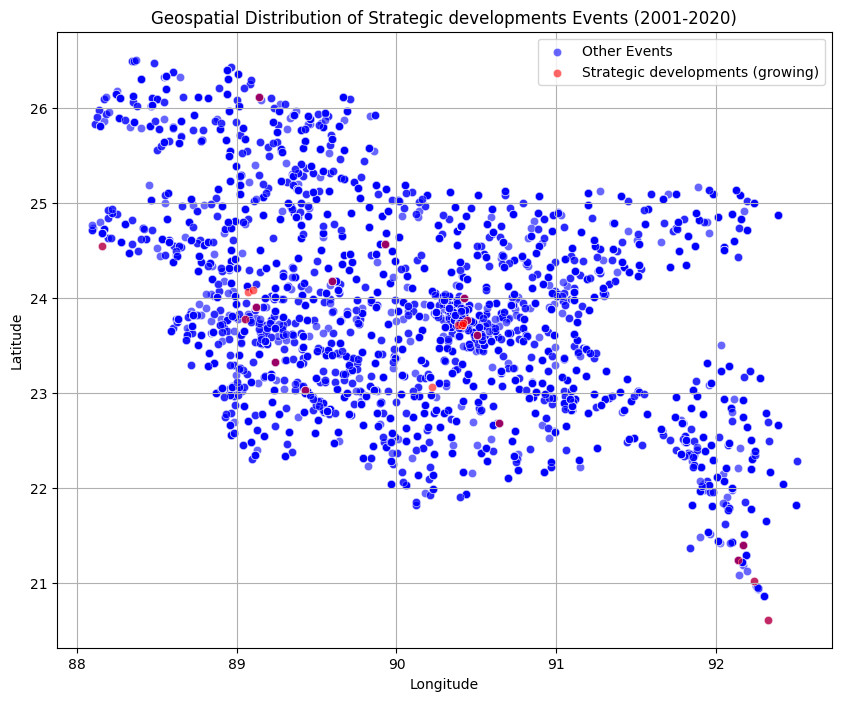

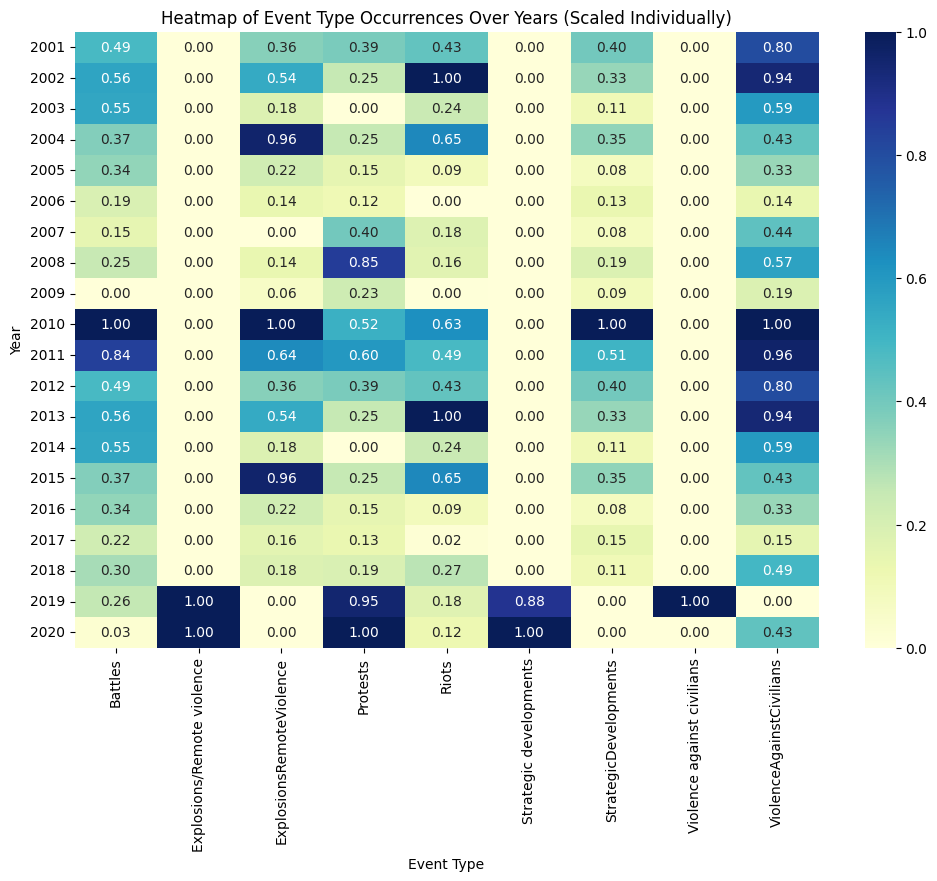

In [1]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive
drive.mount("/content/gdrive")

# Load data from Excel file
data_path1 = '/content/gdrive/MyDrive/FYDP-2_DATA&Code/Copy of ACLED Data.xlsx'
df = pd.read_excel(data_path1)

# Display the first few rows of the dataframe to understand its structure
print(df.head())

# Define the feature columns and target column
feature_cols = ['YEAR', 'LATITUDE', 'LONGITUDE', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']
target_col = 'EVENT_TYPE'

# Select relevant columns
df = df[['YEAR', 'LATITUDE', 'LONGITUDE', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity', 'EVENT_TYPE']]

# Group by YEAR and EVENT_TYPE and count occurrences
event_counts = df.groupby(['YEAR', 'EVENT_TYPE']).size().reset_index(name='count')

# Pivot the table to get years as rows and event types as columns
event_counts_pivot = event_counts.pivot(index='YEAR', columns='EVENT_TYPE', values='count').fillna(0)

# Reset index to make YEAR a column again
event_counts_pivot = event_counts_pivot.reset_index()

# Merge with original features based on YEAR
df_features = df[['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']].drop_duplicates()
merged_data = pd.merge(df_features, event_counts_pivot, on='YEAR')

# Display the merged data
print(merged_data.head())

# Define features (X) and target (y)
X = merged_data[['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']]
y = merged_data.drop(columns=['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity'])

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the target values for the test set
y_pred = model.predict(X)

# Calculate metrics for each event type and determine growth or decline
event_types = y.columns
metrics = {}
trend = {}

for i, event in enumerate(event_types):
    r2 = r2_score(y[event], y_pred[:, i])
    mse = mean_squared_error(y[event], y_pred[:, i])
    mae = mean_absolute_error(y[event], y_pred[:, i])
    metrics[event] = {'R^2': r2, 'MSE': mse, 'MAE': mae}

    # Determine trend based on the slope of the regression line
    model_event = LinearRegression()
    model_event.fit(X[['YEAR']], y[event])
    slope = model_event.coef_[0]
    if slope > 0:
        trend[event] = 'growing'
    elif slope < 0:
        trend[event] = 'declining'
    else:
        trend[event] = 'stable'

# Print all metrics at once
for event, metric in metrics.items():
    print(f"Metrics for {event}:")
    print(f"  R^2: {metric['R^2']:.2f}")
    print(f"  MSE: {metric['MSE']:.2f}")
    print(f"  MAE: {metric['MAE']:.2f}")
    print(f"  Trend: {trend[event]}")
    print()

# Function to create a 2D scatter plot with trend coloring
def plot_trend(df, event_type, trend):
    df_event = df[df['EVENT_TYPE'] == event_type]
    df_other = df[df['EVENT_TYPE'] != event_type]

    # Check trend
    if trend[event_type] == 'growing':
        color_event = 'red'
    elif trend[event_type] == 'declining':
        color_event = 'green'
    else:
        color_event = 'blue'

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(df_other['LONGITUDE'], df_other['LATITUDE'], c='blue', label='Other Events', alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.scatter(df_event['LONGITUDE'], df_event['LATITUDE'], c=color_event, label=f'{event_type} ({trend[event_type]})', alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Geospatial Distribution of {event_type} Events (2001-2020)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the trends for all event types
for event_type in df['EVENT_TYPE'].unique():
    plot_trend(df, event_type, trend)

# Function to create heatmap for event occurrences over years
def plot_heatmap(event_counts_pivot):
    # Scale each column individually
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(event_counts_pivot.set_index('YEAR'))
    scaled_df = pd.DataFrame(scaled_data, columns=event_counts_pivot.columns[1:], index=event_counts_pivot['YEAR'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(scaled_df, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('Heatmap of Event Type Occurrences Over Years (Scaled Individually)')
    plt.xlabel('Event Type')
    plt.ylabel('Year')
    plt.show()

# Plotting the heatmap
plot_heatmap(event_counts_pivot)
